# Spacy Text Classification Modelling

In [1]:
# Load to the data
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import pandas as pd
df_tweets = pd.read_csv('data/tweets_data_lda.csv')
df_tweets.head()

,date,like_count,reply_count,retweet_count,text
0,2011-12-01,267,63,24,{I made the volume on the Model S http://t.co...
1,2011-12-03,82,38,31,"{That was a total non sequitur btw, Great Volt..."
2,2011-12-04,65,17,9,{Am reading a great biography of Ben Franklin ...
3,2011-12-21,1330,87,597,{Yum! Even better than deep fried butter: htt...
4,2011-12-22,1349,132,206,{Model S options are out! Performance in red a...


In [28]:
# Data Pre-processing and make the tweets all lowercase and remove stopwords.
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')
import math
import math
import numpy as np

twitter_df = df_tweets.copy()

# lower the tweets
twitter_df['preprocessed_text'] = twitter_df['text'].str.lower()

# remove apostrophe from words and url
twitter_df['preprocessed_text'] = [re.sub("('[a-z]+)\s", " ", row) for row in twitter_df['preprocessed_text']]
twitter_df['preprocessed_text'] = [re.sub("(')\s", " ", row) for row in twitter_df['preprocessed_text']]
twitter_df['preprocessed_text'] = [re.sub("(?:https:\/\/\S+)\s", "", row) for row in twitter_df['preprocessed_text']]

                                      
# filter out rest URLs
url_re = '(?:https?:\/\/)?(?:[^?\/\s]+[?\/])(.*)'
twitter_df['preprocessed_text'] = twitter_df['preprocessed_text'].apply(lambda row: ' '.join([word for word in row.split() if (not re.match(url_re, word))]))

# tokenize the tweets
tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
twitter_df['tokenized_text'] = twitter_df['preprocessed_text'].apply(lambda row: tokenizer.tokenize(row))

#create an object of class PorterStemmer
porter = PorterStemmer()

# apply stemming
twitter_df['preprocessed_text'] = [porter.stem(row) for row in twitter_df['preprocessed_text']]   

# filter out stop words
en_stop_words = nltk.corpus.stopwords.words('english')
additional_stop_words =['amp', 'rt', 'th','co', 're', 've', 'kim', 'daca', 'us', 'it', 'th', 'you', 'haha', 'st', 'et', 'so', 'iii', 'also', 've', 'la', 're', 'the', 'https', 'wow', 'actually', 'due', 'ft', 'pcr', 'via', 'am', 'gt', 'com', 'since', 'in', 'me', 'and', 'btw', 'yesterday', 'ii', 'inu', 'on', 'http', 'to', 'vs', 'rd', 'ur', 'of', 'bs', 'km', 'est', 'em', 'lz', 'kms', 'aft', 'nd',  'here’s', 're', 'mqxfakpzf' 'mph', 'ht', 'etc', 'dm', 'doo']
en_stop_words.extend(additional_stop_words)

twitter_df['tokenized_text'] = twitter_df['tokenized_text'].apply(lambda row: [word for word in row if (not word in en_stop_words)])

df_tweets_clean = twitter_df.copy()
df_tweets_clean.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gobinaththangaiya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,date,like_count,reply_count,retweet_count,text,preprocessed_text,tokenized_text
0,2011-12-01,267,63,24,{I made the volume on the Model S http://t.co...,{i made the volume on the model s go to 11. no...,"[made, volume, model, go, need, work, miniatur..."
1,2011-12-03,82,38,31,"{That was a total non sequitur btw, Great Volt...","{that was a total non sequitur btw, great volt...","[total, non, sequitur, great, voltaire, quote,..."
2,2011-12-04,65,17,9,{Am reading a great biography of Ben Franklin ...,{am reading a great biography of ben franklin ...,"[reading, great, biography, ben, franklin, isa..."
3,2011-12-21,1330,87,597,{Yum! Even better than deep fried butter: htt...,{yum! even better than deep fried butter: yeah...,"[yum, even, better, deep, fried, butter, yeah,..."
4,2011-12-22,1349,132,206,{Model S options are out! Performance in red a...,{model s options are out! performance in red a...,"[model, options, performance, red, black, deli..."


In [31]:
twitter_df['tokenized_text'] = twitter_df['tokenized_text'].apply(lambda x : len(str(x).split()))
twitter_df.head()

,date,like_count,reply_count,retweet_count,text,preprocessed_text,tokenized_text
0,2011-12-01,267,63,24,{I made the volume on the Model S http://t.co...,{i made the volume on the model s go to 11. no...,23
1,2011-12-03,82,38,31,"{That was a total non sequitur btw, Great Volt...","{that was a total non sequitur btw, great volt...",17
2,2011-12-04,65,17,9,{Am reading a great biography of Ben Franklin ...,{am reading a great biography of ben franklin ...,8
3,2011-12-21,1330,87,597,{Yum! Even better than deep fried butter: htt...,{yum! even better than deep fried butter: yeah...,78
4,2011-12-22,1349,132,206,{Model S options are out! Performance in red a...,{model s options are out! performance in red a...,28


### Bag of Words
If we want to classify text on a topic basis, we often do not want to look at the sequences of words. We do not want to classify text. Instead, we present the text as an unordered word package, ignoring its original position in the text and keeping its frequency.

In [3]:
# define function for counting words
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]

In [4]:
# count words in tweets
words_in_tweets = get_most_freq_words([ word for tweet in df_tweets_clean.tokenized_text for word in tweet])
print(f'Elon Musked used {len(words_in_tweets)} words in his tweets.')
print(f'The most popular words:')
words_in_tweets[:10]

Elon Musked used 8197 words in his tweets.
The most popular words:


[('tesla', 629),
 ('model', 260),
 ('spacex', 245),
 ('good', 180),
 ('launch', 174),
 ('rocket', 166),
 ('car', 160),
 ('falcon', 159),
 ('like', 151),
 ('time', 129)]

In [5]:
# Convert to DataFrame
words_count = pd.DataFrame(words_in_tweets, columns=['Word', 'Count'])
words_count.head()


,Word,Count
0,tesla,629
1,model,260
2,spacex,245
3,good,180
4,launch,174


In [6]:
map = {1: 'Negative', 0: 'Positive'}

In [7]:
# Export word counts to csv
words_count.to_csv('data/words_count.csv', index=False)

### Identify the number of subjects

In [34]:
import pandas as pd
import numpy as np
import spacy
import re
from spacy import displacy
from spacy.util import minibatch, compounding

import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
# Remove Accented Chars
import unicodedata
def remove_acc_data(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

In [38]:
!python -m spacy download en_core_web_sm
# Convert dataset to Base form or Root form :
import spacy 
nlp = spacy.load('en_core_web_sm')
# Dived = dive, time = times, manage= managed 
x = "I made the volume on the Model "

     |████████████████████████████████| 13.7 MB 18.9 MB/s eta 0:00:01     |████████████████████████▏       | 10.3 MB 11.2 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
x = "I made the volume on the Model"
def base(x):
    doc = nlp(x)
    for token in doc:
        lemma = token.lemma_
        lemmma = token.text
        print(lemma, lemmma)

In [23]:
base(x)

I I
make made
the the
volume volume
on on
the the
Model Model


In [45]:
twitter_df['tokenized_text'] = twitter_df['tokenized_text'].apply(lambda x : len(str(x).split()))
twitter_df.head()

,date,like_count,reply_count,retweet_count,text,preprocessed_text,tokenized_text
0,2011-12-01,267,63,24,{I made the volume on the Model S http://t.co...,{i made the volume on the model s go to 11. no...,1
1,2011-12-03,82,38,31,"{That was a total non sequitur btw, Great Volt...","{that was a total non sequitur btw, great volt...",1
2,2011-12-04,65,17,9,{Am reading a great biography of Ben Franklin ...,{am reading a great biography of ben franklin ...,1
3,2011-12-21,1330,87,597,{Yum! Even better than deep fried butter: htt...,{yum! even better than deep fried butter: yeah...,1
4,2011-12-22,1349,132,206,{Model S options are out! Performance in red a...,{model s options are out! performance in red a...,1


In [48]:
# Now we will join whole dataset 
text = " ".join(twitter_df['preprocessed_text'])

In [49]:
# We have whole dataset and we will split it into words so that we can calculate word counts :
text = text.split()
import pandas as pd
#Freq common texts, we can see by converting this text to series of pandas and via value counts we can count all:
freq_words = pd.Series(text).value_counts()

In [50]:
freq_words

the          1603
to           1547
a            1096
of           1068
in            877
             ... 
iron            1
dear            1
prelaunch       1
webbing         1
flight.}        1
Length: 14051, dtype: int64

In [51]:
F20 = freq_words[:20]
F20

the      1603
to       1547
a        1096
of       1068
in        877
is        868
for       685
&amp;     566
on        544
tesla     492
will      469
and       415
be        406
that      350
at        348
it        346
with      316
this      310
by        292
i         290
dtype: int64

In [52]:
# We can also extract rare words by using :
rare = freq_words[freq_words.values == 1]

# Word Cloud Visualization:

In [53]:
!pip install -U textblob
!python -m textblob.download_corpora

     |████████████████████████████████| 636 kB 4.6 MB/s eta 0:00:01
[nltk_data] Downloading package brown to
[nltk_data]     /Users/gobinaththangaiya/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gobinaththangaiya/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gobinaththangaiya/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gobinaththangaiya/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/gobinaththangaiya/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/gobinaththangaiya/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [54]:
pip install wordcloud

     |████████████████████████████████| 220 kB 4.5 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=160440 sha256=d5fc7a9ee02ae90f06aa7d47bd960f129ebf6ce2e79133f610b4d23b38cadb62
  Stored in directory: /Users/gobinaththangaiya/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
Successfully built wordcloud
Note: you may need to restart the kernel to use updated packages.


In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [80]:
x =  ' '.join(text[:20000])
len(x)

119565

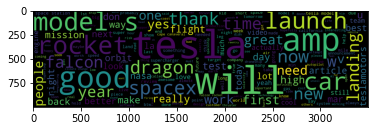

In [81]:
# To visualise wordcloud 
wc = WordCloud(width=3500, height=1000).generate(x)
plt.imshow(wc)

# Spelling Correction:

In [59]:
# We can correct spelling using textblob: 
from textblob import TextBlob
x = ""
TextBlob(x).correct()

TextBlob("")

# Machine Learning Algorithms:

In [61]:
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,accuracy_score
from sklearn.preprocessing import MaxAbsScaler

In [62]:
# n_jobs mean utilize All avalible CPU:  
sgd = SGDClassifier(n_jobs=-1, max_iter=200, random_state=42)
lr = LogisticRegression(max_iter=200, random_state=200)
lrcv = LogisticRegressionCV(cv=2, random_state=42, max_iter=2000)
svm = LinearSVC(random_state=42, max_iter=200)
rfc = RandomForestClassifier(n_estimators=200 , n_jobs=-1, random_state=42)

In [63]:
from IPython.display import Image

In [64]:
# Creating dict so i can train all these algorithms: 
clf = {'SGD' : sgd, 'lr' : lr, 'lrc' : lrcv, 'svm' : svm, 'rfc' : rfc}

In [65]:
clf.keys()

dict_keys(['SGD', 'lr', 'lrc', 'svm', 'rfc'])

In [84]:
# We will convert text to BOW 
print(twitter_df.shape)
# Dataset is huge nd we will take sample size 
df1 = twitter_df[twitter_df['tokenized_text']==0].sample(1000)
df2 = twitter_df[twitter_df['tokenized_text']==1].sample(1000)
# merge this into reduce dataframe
dfr = df1.append(df2)
print(dfr.shape)

(1724, 7)


ValueError: a must be greater than 0 unless no samples are taken